# Knowledge Graph Visualization

In [203]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure

In [204]:
import networkx as nx
import matplotlib.pyplot as plt


### Reading Wiki Entity-Relation data

In [205]:
wiki_data = pd.read_csv('../data/model_predictions_wiki_text_0.8_results.csv', index_col=0)
wiki_data = wiki_data.filter(items=['source_term', 'target_term', 'relation', 'score', 'coocc_term'], axis=1)
wiki_data.head(), len(wiki_data)

(  source_term target_term         relation     score
 0     Machine      Energy    has parameter  0.928493
 1      Energy     Machine  is parameter of  0.942900
 2       Brake        Axle   interacts with  0.994778
 3       Brake    Friction    has parameter  0.973993
 4        Axle       Brake   interacts with  0.996486,
 62942)

### Filtering for high score relations

In [206]:
# filtering for node pairs with score>0.9
score_threshold=0.9
wiki_hg_score_pairs = wiki_data[wiki_data.score>=score_threshold]   #.drop_duplicates(keep='first')
wiki_hg_score_pairs.head(), len(wiki_hg_score_pairs)

(  source_term target_term         relation     score
 0     Machine      Energy    has parameter  0.928493
 1      Energy     Machine  is parameter of  0.942900
 2       Brake        Axle   interacts with  0.994778
 3       Brake    Friction    has parameter  0.973993
 4        Axle       Brake   interacts with  0.996486,
 23889)

### Computing Entity Co-occurrence Frequency

In [207]:
# adding entity pair cooccurrence term
wiki_hg_score_pairs['coocc_term'] = wiki_hg_score_pairs.apply(
    lambda row: (row.source_term+'-'+row.target_term) if row.source_term > row.target_term
    else (row.target_term+'-'+row.source_term),
    axis=1
)


#wiki_hg_score_pairs['count']=1

wiki_hg_score_pairs.head()

<ipython-input-207-f3c0248dc2ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_hg_score_pairs['coocc_term'] = wiki_hg_score_pairs.apply(


,source_term,target_term,relation,score,coocc_term
0,Machine,Energy,has parameter,0.928493,Machine-Energy
1,Energy,Machine,is parameter of,0.942900,Machine-Energy
2,Brake,Axle,interacts with,0.994778,Brake-Axle
3,Brake,Friction,has parameter,0.973993,Friction-Brake
4,Axle,Brake,interacts with,0.996486,Brake-Axle


### Entity pairs wise Relation Distribution (directed)

In [208]:
wiki_hg_score_grp = wiki_hg_score_pairs.copy()
wiki_hg_score_grp['count']=1
wiki_hg_score_grp = wiki_hg_score_grp.groupby(['coocc_term', 'source_term', 'target_term', 'relation', 'score']).count(
).reset_index( #).rename(columns={'coocc_term':'count'}
).sort_values(by='score', ascending=False)
wiki_hg_score_grp.head()

,coocc_term,source_term,target_term,relation,score,count
4495,Lever-Bicycle,Lever,Bicycle,is part of,0.999907,6
4791,Locomotive-Brake shoe,Brake shoe,Locomotive,is part of,0.999903,2
10565,Valve-Train,Valve,Train,is part of,0.999891,2
9561,Train-Cable television,Cable television,Train,is part of,0.999883,2
4490,Lever-Bicycle,Bicycle,Lever,consists of,0.999872,6


In [209]:
# wiki_hg_score_grp.to_csv('../data/wiki_high_score_rels.csv')

In [210]:
len(wiki_hg_score_grp)

12297

### Entity pairs wise Relation Distribution - Pivot Table (undirected pairs)

In [211]:
wiki_ent_pairs = wiki_hg_score_pairs.pivot_table(index=['coocc_term'], 
                                                 #columns='relation', 
                                                 values='source_term',
                                                 aggfunc='count', 
                                                 fill_value=0)
# wiki_ent_pairs['count'] = wiki_top_npairs.iloc[:,:-1].sum(axis=1)
wiki_ent_pairs.rename(columns={'source_term':'count'}, inplace=True)
wiki_ent_pairs.head()

,count
coocc_term,
Air conditioning-Adult contemporary music,6
Aircraft-Accumulator (computing),2
Aircraft-Air brake (road vehicle),2
Aircraft-Air compressor,1
Aircraft-Air gap (networking),1


### Graph Visualization of top N entity pairs (without relation type)

In [212]:
len(wiki_ent_pairs)

4187

In [213]:
top_n=100 # visualize entities by their relation weight (count)

wiki_df = wiki_ent_pairs.reset_index().sort_values(by='count', ascending=False)[:top_n][['coocc_term', 'count']]
wiki_df['node1'] = wiki_df.coocc_term.apply(lambda term: term.split('-')[0])
wiki_df['node2'] = wiki_df.coocc_term.apply(lambda term: term.split('-')[1])
wiki_df.head()

,coocc_term,count,node1,node2
1386,Lever-Brake,322,Lever,Brake
3988,Wheel-Brake,303,Wheel,Brake
71,Brake pad-Brake,295,Brake pad,Brake
523,Drum brake-Brake,236,Drum brake,Brake
913,Friction-Brake,226,Friction,Brake


In [214]:
len(wiki_df)

100

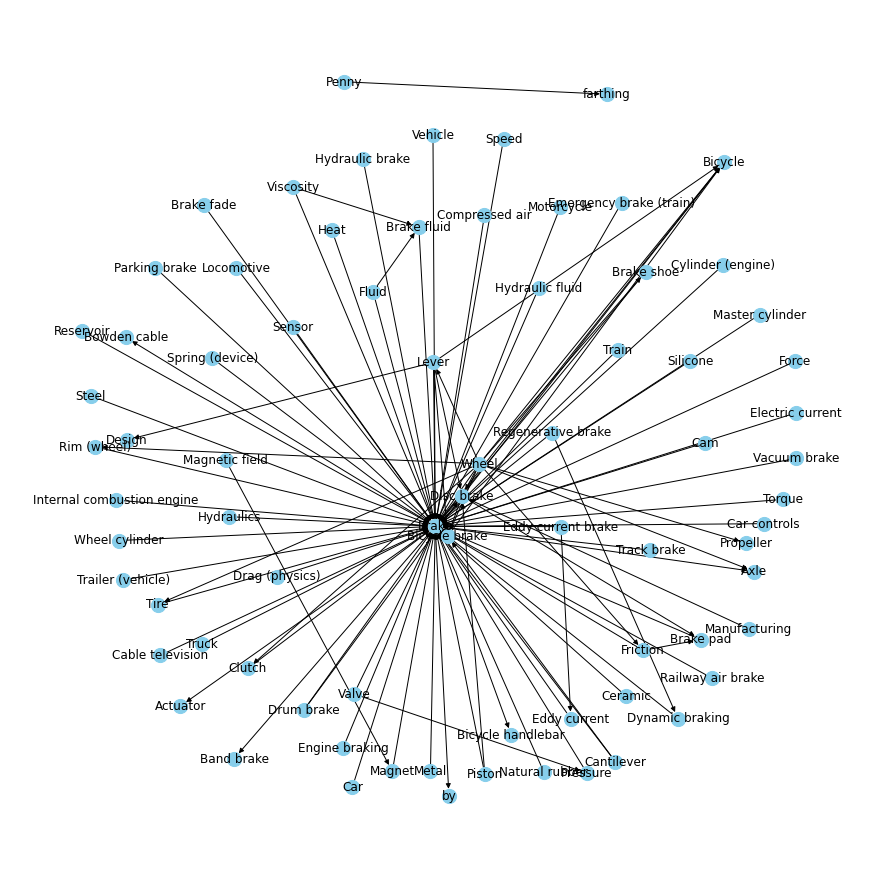

In [215]:
G=nx.from_pandas_edgelist(wiki_df, "node1", "node2", # [kg_df2['type']=="has part"]

# G=nx.from_pandas_edgelist(wiki_ent_df[# (wiki_hg_score_grp.relation=='has parameter')
#                                             (wiki_hg_score_grp.target_term=='Heat')
#                                             #& (wiki_hg_score_grp.source_term=='Brake')
#                                            ],
#                           "source_term", "target_term", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
figure(figsize=(12, 12))
pos=nx.spring_layout(G, k=0.8)
# nx.draw_shell(G, with_labels=True)

# random_state_index is incorrect --> I had the problem with decorator 5.0.6, but upgrading to 5.1 fixed it
nx.draw(G, with_labels=True, node_color='skyblue', node_size=200, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Enhancing Visualization with additional Channels

### Manual Annotation of Entity Types

Since the custom entity types could not be acquired from Wikifier Entity Extraction utility, the same were annotated manually for all entities above the threshold relation score.

In [216]:
# entity vocab
entity_type_df = pd.read_csv('../data/wiki_entity_vocab.csv')

entity_vocab = {}
for idx,ent_type in entity_type_df.iterrows():
    entity = ent_type.entity
    etype = ent_type.type
    entity_vocab[entity]=etype

In [217]:
# mapping entity types to source and target entities in wiki data

wiki_ent_df = wiki_hg_score_pairs.copy()
wiki_ent_df['source_type'] = wiki_ent_df.source_term.apply(lambda entity: entity_vocab[entity] if entity in entity_vocab.keys() else 'unknown')
wiki_ent_df['target_type'] = wiki_ent_df.target_term.apply(lambda entity: entity_vocab[entity] if entity in entity_vocab.keys() else 'unknown')
wiki_ent_df.head()

,source_term,target_term,relation,score,coocc_term,source_type,target_type
0,Machine,Energy,has parameter,0.928493,Machine-Energy,product,parameter
1,Energy,Machine,is parameter of,0.942900,Machine-Energy,parameter,product
2,Brake,Axle,interacts with,0.994778,Brake-Axle,system,system
3,Brake,Friction,has parameter,0.973993,Friction-Brake,system,parameter
4,Axle,Brake,interacts with,0.996486,Brake-Axle,system,system


In [218]:
# entities with unknown node types
wiki_ent_df[wiki_ent_df.target_type=='unknown']['target_term'].count()

2394

In [219]:
len(wiki_ent_df)

23889

### Filtering for Top-n High Score Entities 

In [220]:
wiki_rel_df = pd.merge(wiki_ent_df, wiki_df, on='coocc_term')
wiki_rel_df.head()

,source_term,target_term,relation,score,coocc_term,source_type,target_type,count,node1,node2
0,Brake,Axle,interacts with,0.994778,Brake-Axle,system,system,28,Brake,Axle
1,Axle,Brake,interacts with,0.996486,Brake-Axle,system,system,28,Brake,Axle
2,Brake,Axle,interacts with,0.995107,Brake-Axle,system,system,28,Brake,Axle
3,Axle,Brake,interacts with,0.996928,Brake-Axle,system,system,28,Brake,Axle
4,Axle,Brake,interacts with,0.996099,Brake-Axle,system,system,28,Brake,Axle


In [221]:
len(wiki_rel_df)

7026

### Visualization of Directed Graph

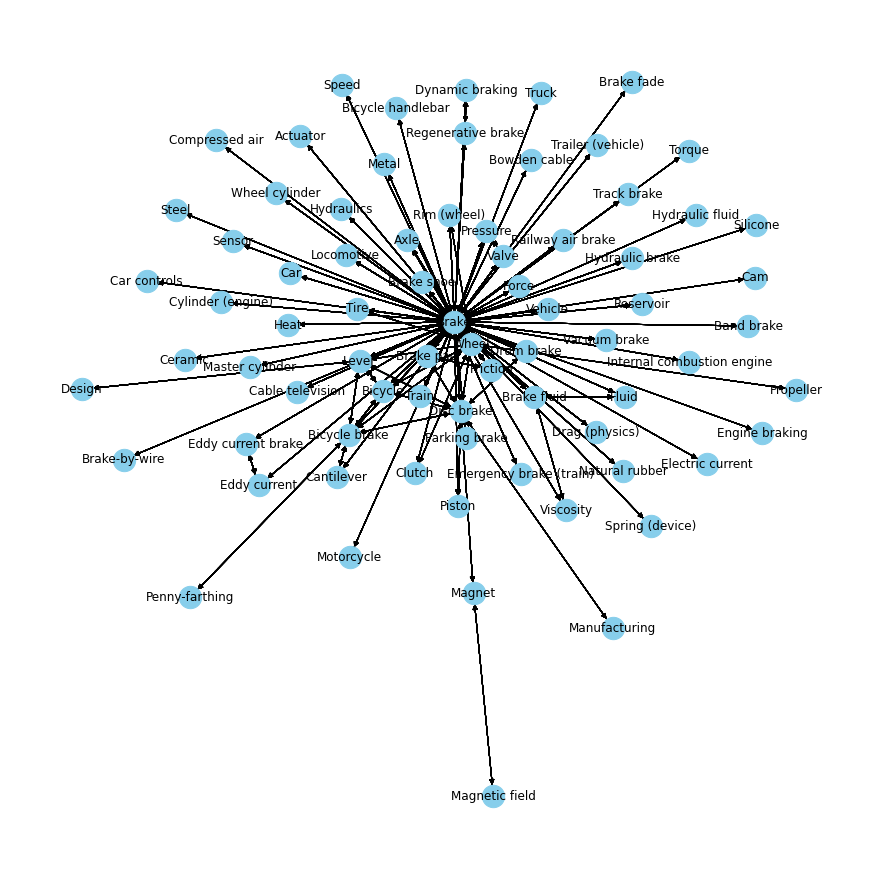

In [222]:
G=nx.from_pandas_edgelist(wiki_rel_df, "target_term", "source_term", # [kg_df2['type']=="has part"]
                          edge_attr=True, create_using=nx.MultiDiGraph()) #random_geometric_graph(len(wiki_rel_df), 0.125)) #
figure(figsize=(12, 12))
pos=nx.spring_layout(G, k=0.8)
# nx.draw_shell(G, with_labels=True)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Assigning Vis Channels to nodes and edges

In [223]:
import matplotlib

def plot_graph2(df, layout):
    # Create graph object using relationships DF
    G = nx.from_pandas_edgelist(df, 'source_term', 'target_term', create_using=layout)


    # Create DF for node characteristics
    src_terms_df = df.groupby(['source_term', 'source_type']).size().reset_index()
    tgt_terms_df = df.groupby(['target_term', 'target_type']).size().reset_index()

    src_terms_df.rename(columns={'source_term':'entity', 'source_type':'type', 0:'weight'}, inplace=True)
    tgt_terms_df.rename(columns={'target_term':'entity', 'target_type':'type', 0:'weight'}, inplace=True)

    terms_df = src_terms_df.append(tgt_terms_df).groupby(['entity', 'type']).sum().reset_index(level=1)

    terms_df = terms_df.reindex(G.nodes())

    terms_df['type'] = pd.Categorical(terms_df['type'])

    # Set node size by type
    node_sizes = [5000 if weight in range(3000, 5000) 
                  else 3500 if weight in range(500, 3000) 
                  else 2000 if weight in range(100, 500) 
                  else 1000
                  for weight in terms_df.weight]

    # Set edge colors and edge colors
    color_set = ['blue', 'red', 'green', 'orange', 'black', 'cyan', 'skyblue', 'pink', 'grey', 'yellow']
    edge_colors = [color_set[i] for i in terms_df['type'].cat.codes]


    # edge width by the relationship weight (count)
    entity_edges = df.groupby('coocc_term')['relation'].count()
    
    counts=[]
    for edge in G.edges():
        coocc_term = edge[0]+'-'+edge[1] if edge[0]>edge[1] else edge[1]+'-'+edge[0]
        counts.append(entity_edges[coocc_term])

    edge_widths = [6 if weight in range(300, 500) 
                   else 3 if weight in range(200, 300) 
                   else 1.5 if weight in range(100, 200) 
                   else 0.5
                   for weight in counts]

    # Set color map
    cmap = matplotlib.colors.ListedColormap(['orange', 'lightgray', 'dodgerblue', 'pink', 'skyblue'])

    # Draw the graph and specify our characteristics
    figure(figsize=(12, 12))

    nx.draw(G, with_labels=True, node_color=terms_df['type'].cat.codes, cmap=cmap, 
            node_size=node_sizes, font_size=12, width=edge_widths, #font_weight="bold",
            edgecolors='gray', edge_color=edge_colors)

    plt.show()


In [224]:
wiki_rel_df['source_type'].unique()

array(['system', 'parameter', 'type', 'product', 'part'], dtype=object)

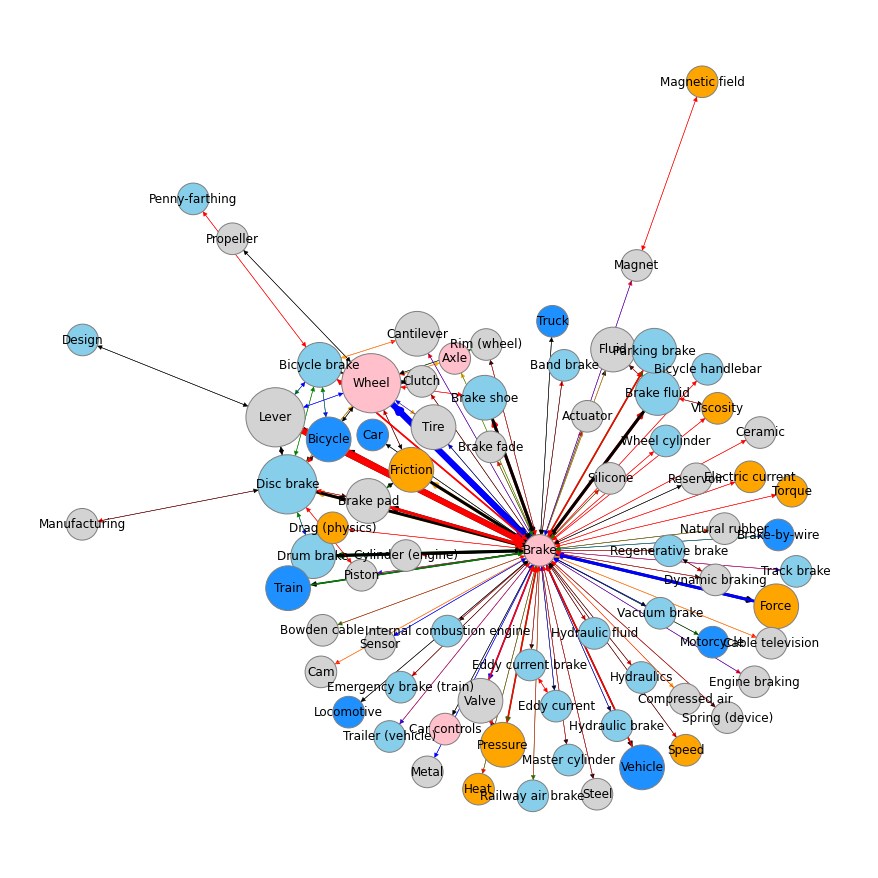

In [225]:
plot_graph2(wiki_rel_df, nx.DiGraph())

Here we assign the following visualization channels:
 - Node Color : Entity Type
 - Node Size  : Entity Rank
 - Edge Color : Relation Type
 - Edge Width : Relation Weight
 - Edge Arrow : Relation direction

### A few more layouts of the Network Graph

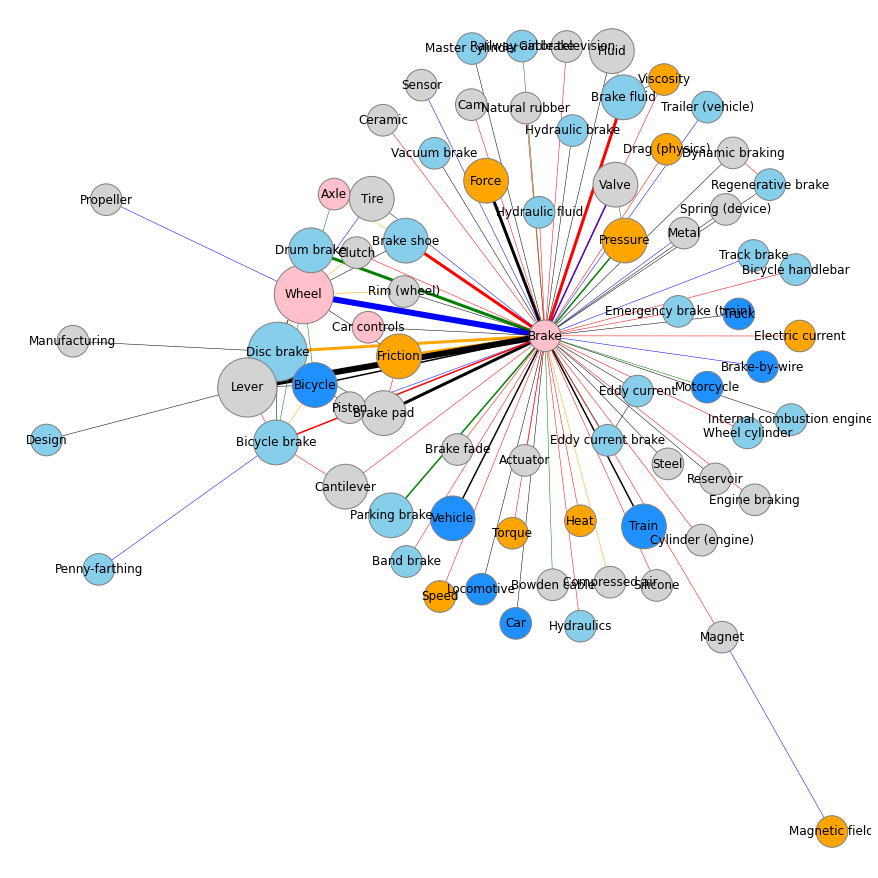

In [226]:
# plot_graph(wiki_rel_df, nx.generators.classic.balanced_tree(3,3))
# plot_graph(wiki_rel_df, nx.grid_graph(dim=[2, 3, 4]))
# plot_graph(wiki_rel_df, nx.MultiGraph())
#plot_graph(wiki_rel_df, nx.OrderedGraph())
# plot_graph(wiki_rel_df, nx.dodecahedral_graph()) 
plot_graph2(wiki_rel_df, nx.petersen_graph())

In [227]:
len(G.nodes())

75

In [228]:
def get_node_characteristics(df, graph):
    
    # Create DF for node characteristics
    src_terms_df = df.groupby(['source_term', 'source_type']).size().reset_index()
    tgt_terms_df = df.groupby(['target_term', 'target_type']).size().reset_index()
    src_terms_df.rename(columns={'source_term':'entity', 'source_type':'type', 0:'weight'}, inplace=True)
    tgt_terms_df.rename(columns={'target_term':'entity', 'target_type':'type', 0:'weight'}, inplace=True)
    terms_df = src_terms_df.append(tgt_terms_df).groupby(['entity', 'type']).sum().reset_index(level=1)
    terms_df = terms_df.reindex(graph.nodes())
    terms_df['type'] = pd.Categorical(terms_df['type'])
    
    return terms_df

In [229]:
def get_node_size_n_colors(df, graph):

    terms_df = get_node_characteristics(df, graph)
    # Set node size by type
    node_sizes = [5000 if weight in range(3000, 5000) 
                  else 3500 if weight in range(500, 3000) 
                  else 2000 if weight in range(100, 500) 
                  else 1000
                  for weight in terms_df.weight]
    
    node_colors = terms_df['type'].cat.codes
    
    return node_sizes, node_colors

In [230]:
def get_edge_widths(df, graph):
    entity_edges = df.groupby('coocc_term')['relation'].count()

    counts=[]
    for edge in graph.edges():
        coocc_term = edge[0]+'-'+edge[1] if edge[0]>edge[1] else edge[1]+'-'+edge[0]
        counts.append(entity_edges[coocc_term])

    edge_widths = [6 if weight in range(300, 500) 
                   else 3 if weight in range(200, 300) 
                   else 1.5 if weight in range(100, 200) 
                   else 0.5
                   for weight in counts]
    return edge_widths

In [231]:
def get_edge_colors(df, graph):
    
    terms_df = get_node_characteristics(df, graph)
    color_set = ['blue', 'red', 'green', 'orange', 'black', 'cyan', 'skyblue', 'pink', 'grey', 'yellow']
    edge_colors = [color_set[i] for i in terms_df['type'].cat.codes]
    return edge_colors

In [232]:
import matplotlib

def plot_graph(df1, layout, is_with_labels):
    
    # Create graph object using relationships DF
    G = nx.from_pandas_edgelist(df1, 'source_term', 'target_term', create_using=nx.DiGraph())
    # pos=nx.spring_layout(G, seed=seed)


    node_sizes, node_colors = get_node_size_n_colors(df1, G)  # Get Node sizes by type

    edge_widths = get_edge_widths(df1, G) # edge width by the relationship weight (count)

    edge_colors = get_edge_colors(df1, G) # Set edge colors and edge colors

    # Set color map
    cmap = matplotlib.colors.ListedColormap(['orange', 'lightgray', 'dodgerblue', 'pink', 'skyblue'])

    # Draw the graph and specify our characteristics
    figure(figsize=(12, 12))

    layout = layout
    is_with_labels=True

    options = {
            'with_labels':is_with_labels, 'node_color': node_colors, 'cmap':cmap, 
            'node_size':node_sizes, 'font_size':12, 'width':edge_widths, #font_weight="bold",
            'edgecolors':'gray', 'edge_color':edge_colors
    }

    if layout=='circular':
        nx.draw_circular(G, **options)
    if layout=='shell':
        nx.draw_shell(G, **options)
    if layout=='spring':
        nx.draw_spring(G, **options)
    if layout=='planar':
        nx.draw_planar(G, **options)
    
    plt.show()

### Q1. What all entities are related with the Brake System?

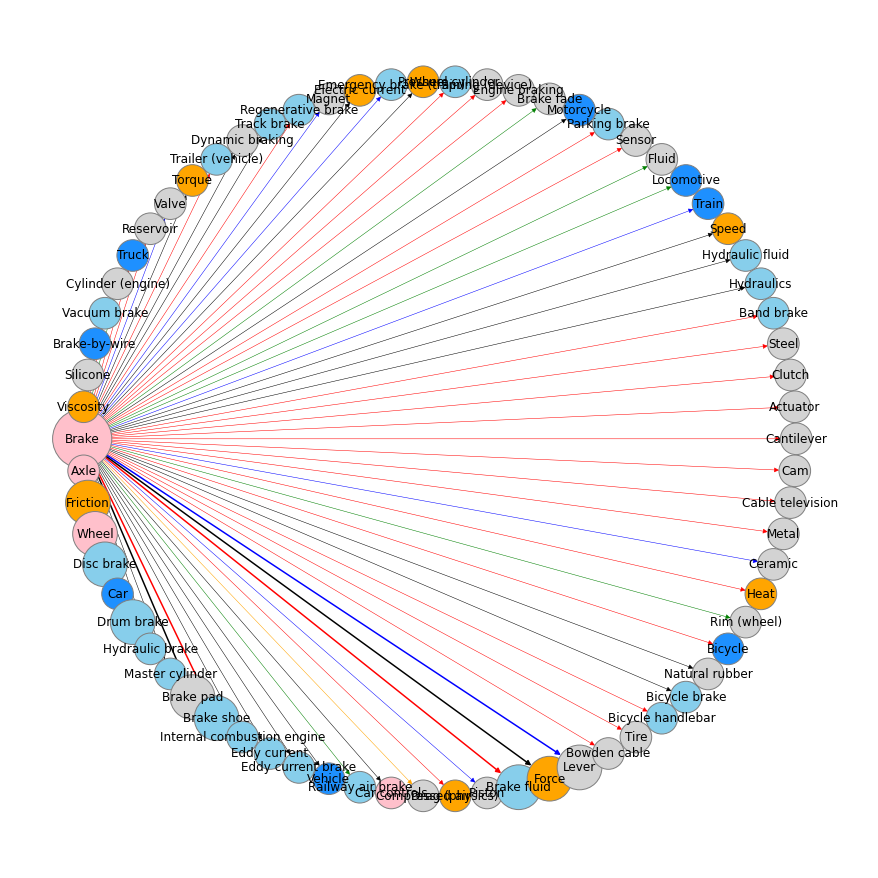

In [233]:
df1 = wiki_rel_df[wiki_rel_df['source_term']=='Brake']
plot_graph(df1, 'shell', is_with_labels=True)

### Q2. What all parameters does the Brake System have?

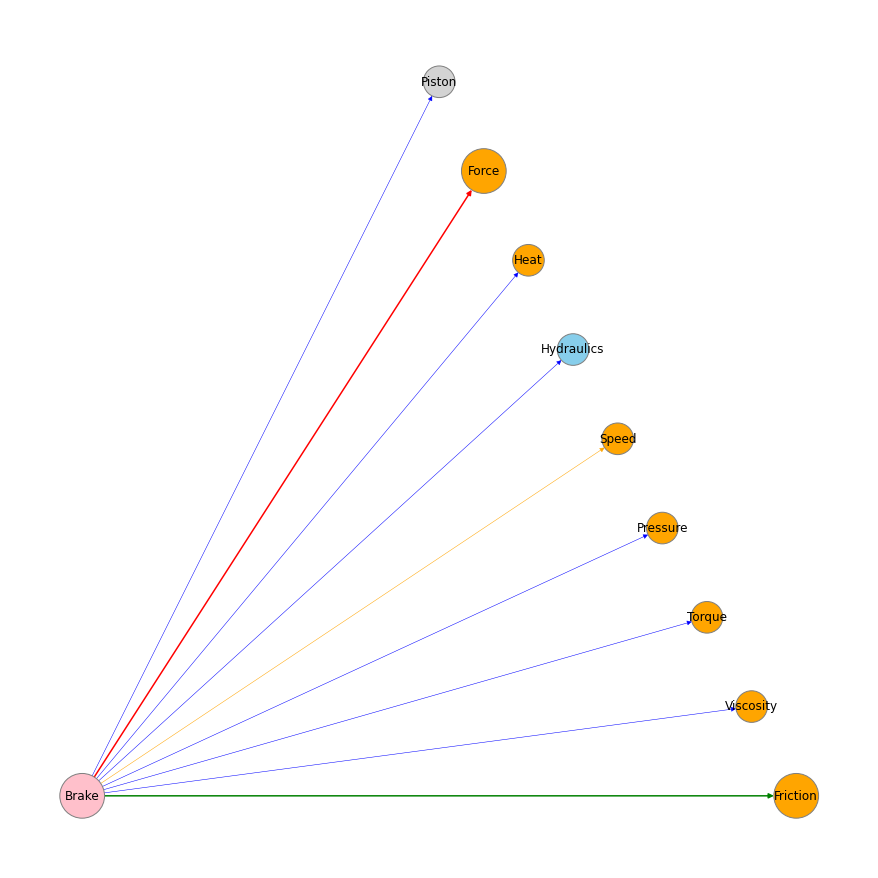

In [234]:
df1 = wiki_rel_df[(wiki_rel_df['source_term']=='Brake') & (wiki_rel_df['relation']=='has parameter')]
plot_graph(df1, 'planar', is_with_labels=True)

### Q3. What Products the Brake system is used in?

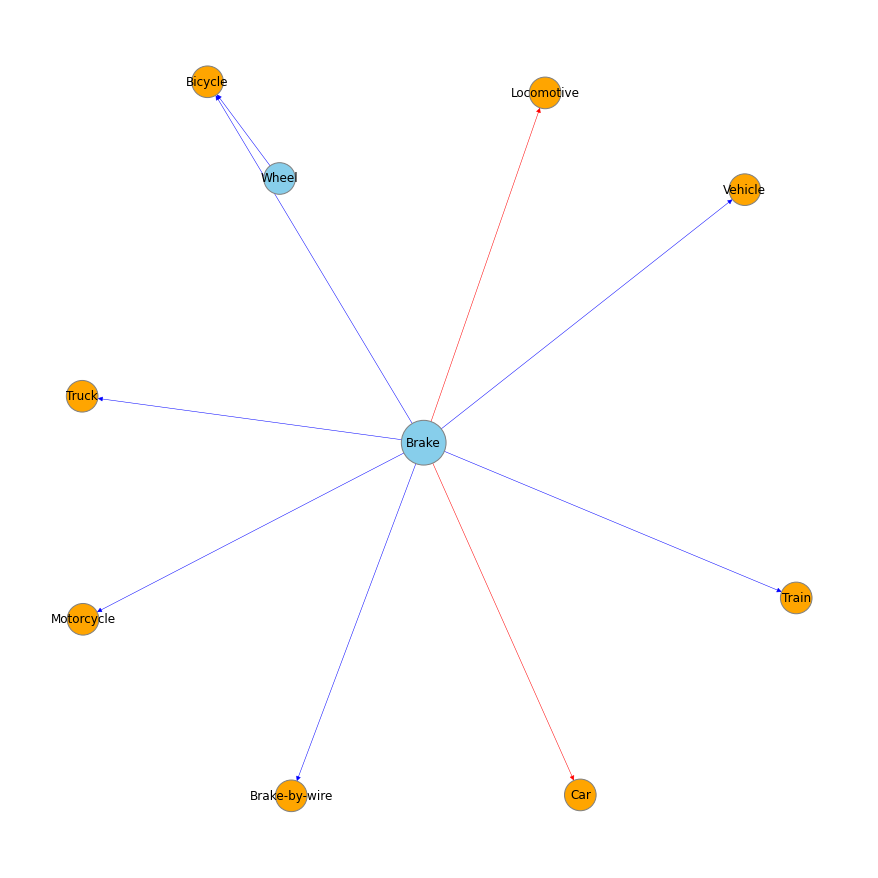

In [246]:
df1 = wiki_rel_df[(wiki_rel_df['source_type']=='system') & (wiki_rel_df['target_type']=='product')]
plot_graph(df1, 'spring', is_with_labels=True)

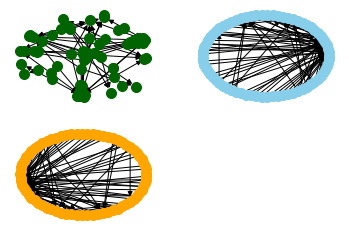

In [315]:
options = {
    'node_color': 'darkgreen',
    'node_size': 100,
    'width': 1,
}

subax1 = plt.subplot(221)
draw_spring(G, **options)

subax2 = plt.subplot(222)
options['node_color']='skyblue'
draw_circular(G, **options)

subax3 = plt.subplot(223)
options['node_color']='orange'
draw_shell(G, **options)

# subax4 = plt.subplot(224)
# options['node_color']='pink'
# draw_planar(G, **options)

In [248]:
len(G.nodes()), len(G.edges())

(10, 15)

### Data Integration - Visualization

In [301]:
bom_df = pd.read_csv('../data/wiki_bom.csv', index_col=0)
bom_df.head()

,source_term,target_term,relation,source_type,target_type
0,DSC BRK WHL_Part Number - 1,Front Rotor and Shield,belongs to,ebom,part category
1,DSC BRK WHL_Part Number - 2,Front Rotor and Shield,belongs to,ebom,part category
2,DSC BRK WHL_Part Number - 3,Front Rotor and Shield,belongs to,ebom,part category
3,DSC BRK WHL_Part Number - 4,Front Rotor and Shield,belongs to,ebom,part category
4,DSC BRK WHL_Part Number - 5,Front Rotor and Shield,belongs to,ebom,part category


### Add Cooccurrence Term

In [302]:
bom_df['coocc_term'] = bom_df.apply(lambda row: 
                                    str(row.source_term)+'='+str(row.target_term) 
                                    if str(row.source_term) > str(row.target_term)
                                    else str(row.target_term)+'='+str(row.source_term), axis=1
                                   )
bom_df[:10]

,source_term,target_term,relation,source_type,target_type,coocc_term
0,DSC BRK WHL_Part Number - 1,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
1,DSC BRK WHL_Part Number - 2,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
2,DSC BRK WHL_Part Number - 3,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
3,DSC BRK WHL_Part Number - 4,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
4,DSC BRK WHL_Part Number - 5,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
5,DSC BRK WHL_Part Number - 6,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
6,DSC BRK WHL_Part Number - 7,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
7,DSC BRK WHL_Part Number - 8,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
8,DSC BRK WHL_Part Number - 9,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...
9,DSC BRK WHL_Part Number - 10,Front Rotor and Shield,belongs to,ebom,part category,Front Rotor and Shield=DSC BRK WHL_Part Number...


### Visualizing Integrated Data from Requirements/BOM domain

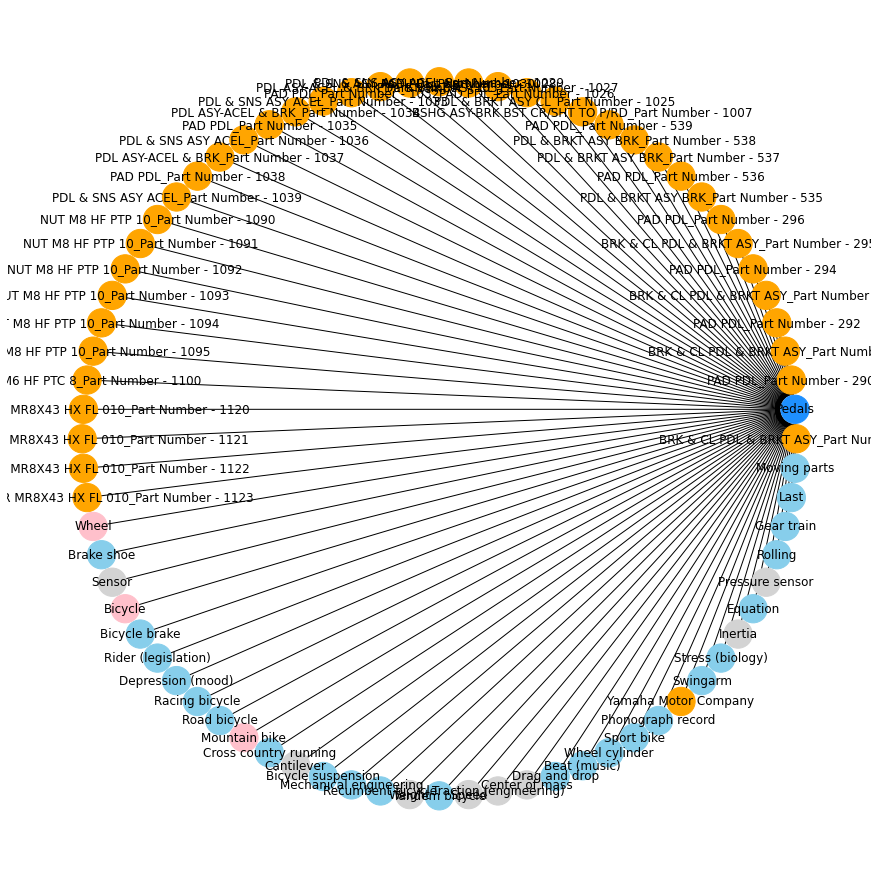

In [329]:
# Create graph object using relationships DF
G = nx.from_pandas_edgelist(bom_df[bom_df.target_term=='Pedals'], 'source_term', 'target_term', create_using=nx.DiGraph())

cmap = matplotlib.colors.ListedColormap(['orange', 'lightgray', 'dodgerblue', 'pink', 'skyblue'])
node_sizes, node_colors = get_node_size_n_colors(bom_df, G)  # Get Node sizes by type

options = {
    'node_color':node_colors,
    'cmap':cmap,
    'with_labels':True,
    'node_size':800
}

figure(figsize=(12, 12))

nx.draw_circular(G, **options) 

### The above visualization shows all the BOM Parts as well as the Requirement Entities associated to the selected Part categories.